### 加载packages

In [3]:
# !pip install -q causal-learn graphviz networkx econml # pygraphviz pyvis
# !pip install git+https://github.com/py-why/dowhy@main
# !apt-get install graphviz libgraphviz-dev -y
# !pip install pygraphviz

import dowhy
from dowhy import CausalModel

import numpy as np
import pandas as pd
import graphviz
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt

from functools import partial
from dowhy import gcm
from dowhy.utils.plotting import plot
from scipy import stats
from statsmodels.stats.multitest import multipletests

np.set_printoptions(precision=4, suppress=True)
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

gcm.util.general.set_random_seed(0)
%matplotlib inline


这里加载数据

In [ ]:
file_path = '../public/sales_attribution.csv'
df = pd.read_csv(file_path, index_col=0)

df.head()

,dsp_spend,sp_spend,dpv,discount,sale,activity_date,year,quarter,month,special_shopping_event,other_shopping_event
0,11864.799390,2609.702789,54954.823150,26167.824599,76740.886670,2023-01-01,2023,1,1,No,No
1,11084.057110,2568.540570,44907.063324,22340.009780,52480.718941,2023-01-02,2023,1,1,No,No
2,16680.850945,2847.576700,151643.912564,68301.747813,628062.966309,2023-01-03,2023,1,1,No,No
3,15473.576264,2788.515831,121173.343955,18906.050402,307547.583964,2023-01-04,2023,1,1,No,No
4,10308.414302,2523.591011,36234.267337,18198.689563,35602.101926,2023-01-05,2023,1,1,No,No


# 📊 Causal Root Cause Attribution — Part 1: Data Ingestion & Baseline Analysis

本部分的目标是：  
- 用户上传原始数据 (CSV/Excel/Parquet/DB) 后，能够选择时间区间、指标，并得到 **基础统计对比表**、**分布图 (KDE)**、**时间序列对比图**，以及新旧数据子集 (df_before / df_after)，供后续步骤使用。

---

## 🔹 用户需要指定的内容

1. **时间列 (time_col)**  
   - 类型：下拉菜单 (Dropdown)  
   - 选项：数据表中的所有列名  
   - 用途：指定时间维度 (如 `month`, `week`)  

2. **年份列 (period_col, 可选)**  
   - 类型：下拉菜单 (Dropdown，可为空)  
   - 选项：数据表中的所有列名  
   - 用途：如果数据包含年份 (如 `year`)，则选定。否则留空。  

3. **Before 时间区间 (before_range)**  
   - 类型：滑动条 (Slider) 或多选框 (Multi-select)  
   - 用途：选择作为 "旧数据" 的时间范围  
   - 示例：  
     - 如果有 year+month: `{ "year": [2023], "month": [1,2,3,4,5,6] }`  
     - 如果只有 month: `[1,2,3,4,5,6]`  

4. **After 时间区间 (after_range)**  
   - 类型：滑动条 (Slider) 或多选框 (Multi-select)  
   - 用途：选择作为 "新数据" 的时间范围  
   - 示例：  
     - 如果有 year+month: `{ "year": [2024], "month": [1,2,3,4,5,6] }`  
     - 如果只有 week: `[20,21,22,23,24,25]`  

5. **分析指标 (main_metric)**  
   - 类型：下拉菜单 (Dropdown)  
   - 选项：所有数值型字段 (Numeric columns)  
   - 用途：指定主要对比的指标 (如 `sale`)  
   - 注意：虽然所有数值列都会在表格中输出，但只会用 `main_metric` 来画图。  

---

## 🔹 系统输出内容

当用户完成上述配置后，系统会执行 `analyze_shift_flexible(...)` 函数，并返回以下结果：

1. **统计对比表 (comparison_df)**  
   - 包含所有数值型列的变化情况：  
     - Δ mean (%)  
     - Δ median (%)  
     - Δ variance (%)  
   - 用途：快速对比 Before vs After 的整体差异  

2. **分布对比图 (KDE Plot)**  
   - 针对 `main_metric`  
   - 对比 Before 和 After 的分布形状  

3. **时间序列对比图 (Time Series Plot)**  
   - 针对 `main_metric`  
   - 按照 `time_col` (如 month/week) 聚合平均值  
   - 绘制 Before vs After 的两条线  

4. **数据子集 (df_before, df_after)**  
   - 切分后的旧数据与新数据  
   - 将作为后续因果归因分析的输入  

5. **数据预览 (Taste)**  
   - 原始数据前 10 行，用于快速确认数据格式和内容  

---

## 🔹 用户交互流程 (UI Flow)

1. **上传数据**  
   - 入口：文件上传框 (支持 CSV, Excel, Parquet)  
   - 系统读取数据后展示前 10 行 (Taste)  

2. **选择时间维度**  
   - Step 1: 从下拉菜单选择 `time_col` (必选)  
   - Step 2: 如果有年份字段，可以在下拉菜单选择 `period_col` (可选)  

3. **选择时间范围**  
   - Step 3: 使用两个滑动条/多选框，分别选择 Before 和 After 的时间范围  
   - 示例：  
     - Before: 2023年 1-6月  
     - After: 2024年 1-6月  

4. **选择目标指标 (main_metric)**  
   - Step 4: 从下拉菜单选择一个数值列作为分析指标 (如 `sale`)  

5. **运行分析**  
   - 点击 "Run Analysis" (或者ingest data) 按钮后，系统执行函数，输出结果  

---

## 🔹 函数调用示例

```python
comparison, df_new, df_old = analyze_shift_flexible(
    df,
    time_col="month",# 用户指定
    period_col="year",# 用户指定
    before_range={"year":[2023], "month":[1,2,3,4,5,6]}, # 用户指定
    after_range={"year":[2024], "month":[1,2,3,4,5,6]}, # 用户指定
    main_metric="sale"  # 用户在UI中指定的目标指标
)


In [8]:
def analyze_shift_flexible(
    df,
    time_col,               # 主时间列，比如 "month" 或 "week"
    before_range,           # before 时间范围 (list / range 或 dict)
    after_range,            # after 时间范围 (list / range 或 dict)
    period_col=None,        # 可选：年份列，比如 "year"
    main_metric="sale",     # 用来画图的主指标
    alpha=0.05              # 显著性阈值
):
    # ---- Step 1: 切分数据 ----
    if period_col:
        df_before = df[(df[time_col].isin(before_range[time_col])) &
                       (df[period_col].isin(before_range[period_col]))].copy()
        df_after  = df[(df[time_col].isin(after_range[time_col])) &
                       (df[period_col].isin(after_range[period_col]))].copy()
    else:
        df_before = df[df[time_col].isin(before_range)].copy()
        df_after  = df[df[time_col].isin(after_range)].copy()

    df_before["period"] = "Before"
    df_after["period"]  = "After"

    # ---- Step 2: 自动获取数值型指标 (排除时间列) ----
    exclude_cols = {time_col}
    if period_col:
        exclude_cols.add(period_col)
    numeric_cols = [
        col for col in df_after.select_dtypes(include=[np.number]).columns
        if col not in exclude_cols
    ]

    comparison_data = []
    for metric in numeric_cols:
        mean_old, mean_new = df_before[metric].mean(), df_after[metric].mean()
        median_old, median_new = df_before[metric].median(), df_after[metric].median()
        var_old, var_new = df_before[metric].var(), df_after[metric].var()

        mean_change = ((mean_new - mean_old) / mean_old * 100) if mean_old != 0 else None
        median_change = ((median_new - median_old) / median_old * 100) if median_old != 0 else None
        var_change = ((var_new - var_old) / var_old * 100) if var_old != 0 else None

        # 统计显著性检验
        try:
            t_stat, p_val = stats.ttest_ind(
                df_after[metric].dropna(),
                df_before[metric].dropna(),
                equal_var=False  # Welch's t-test
            )
        except Exception:
            p_val = None

        # 显著性标注
        significant = "Yes" if (p_val is not None and p_val < alpha) else "No"

        comparison_data.append({
            'Metric': metric,
            'Δ mean (%)': mean_change,
            'Δ median (%)': median_change,
            'Δ variance (%)': var_change,
            'p-value': p_val,
            'Significant Change': significant
        })

    comparison_df = pd.DataFrame(comparison_data)

    # ---- Step 3a: 分布对比 (KDE) ----
    if main_metric in numeric_cols:
        fig, ax = plt.subplots(figsize=(6,4))
        kde_new = stats.gaussian_kde(df_after[main_metric].dropna())
        kde_old = stats.gaussian_kde(df_before[main_metric].dropna())
        x_range = np.linspace(
            min(df_after[main_metric].min(), df_before[main_metric].min()),
            max(df_after[main_metric].max(), df_before[main_metric].max()),
            1000
        )
        ax.plot(x_range, kde_new(x_range), color='#FF6B6B', lw=2, label='After')
        ax.plot(x_range, kde_old(x_range), color='#4ECDC4', lw=2, label='Before')
        ax.fill_between(x_range, kde_new(x_range), alpha=0.3, color='#FF6B6B')
        ax.fill_between(x_range, kde_old(x_range), alpha=0.3, color='#4ECDC4')
        ax.set_title(f"Distribution of {main_metric}")
        ax.set_xlabel(main_metric)
        ax.set_ylabel("Density")
        ax.legend()
        ax.grid(True, linestyle="--", alpha=0.6)
        plt.show()

    # ---- Step 3b: 时间序列对比 ----
    combined = pd.concat([df_before, df_after])
    grouped = combined.groupby(["period", time_col])[main_metric].mean().reset_index()

    fig, ax = plt.subplots(figsize=(8,4))
    for label, grp in grouped.groupby("period"):
        ax.plot(grp[time_col], grp[main_metric], marker="o", label=label, lw=2)

    ax.set_title(f"Time Series of {main_metric} (Avg by {time_col})")
    ax.set_xlabel(time_col)
    ax.set_ylabel(main_metric)
    ax.legend()
    ax.grid(True, linestyle="--", alpha=0.6)
    plt.show()

    display(comparison_df)

    # ---- Step 4: 数据 taste ----
    print("🔍 Data sample (first 10 rows):")
    display(df.head(10))

    return comparison_df, df_after, df_before


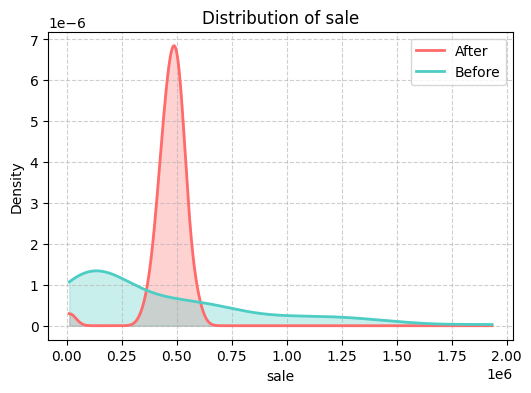

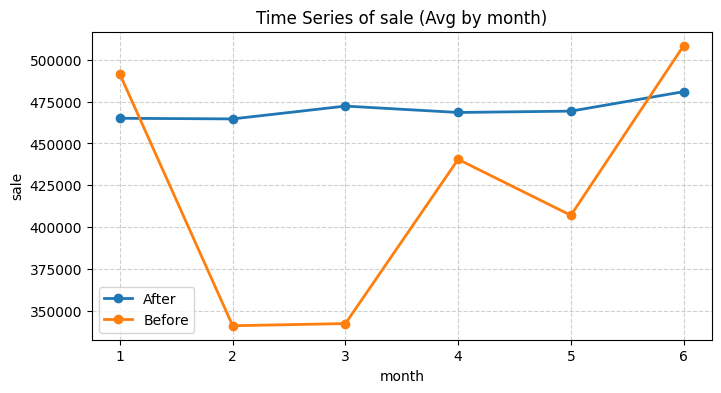

,Metric,Δ mean (%),Δ median (%),Δ variance (%),p-value,Significant Change
0,dsp_spend,6.387894,3.718354,-6.620384e+01,9.146305e-05,Yes
1,sp_spend,10.335289,10.013358,3.126055e+02,5.008180e-27,Yes
2,dpv,8.843596,12.453083,-9.591321e+01,2.517514e-02,Yes
3,discount,-1.837933,32.438169,-9.957096e+01,7.563817e-01,No
4,sale,11.274001,84.089817,-9.597200e+01,1.359526e-01,No
5,quarter,-0.183824,-25.000000,2.208246e-14,9.581702e-01,No


🔍 Data sample (first 10 rows):


,dsp_spend,sp_spend,dpv,discount,sale,activity_date,year,quarter,month,special_shopping_event,other_shopping_event
0,11864.799390,2609.702789,54954.823150,26167.824599,7.674089e+04,2023-01-01,2023,1,1,No,No
1,11084.057110,2568.540570,44907.063324,22340.009780,5.248072e+04,2023-01-02,2023,1,1,No,No
2,16680.850945,2847.576700,151643.912564,68301.747813,6.280630e+05,2023-01-03,2023,1,1,No,No
3,15473.576264,2788.515831,121173.343955,18906.050402,3.075476e+05,2023-01-04,2023,1,1,No,No
4,10308.414302,2523.591011,36234.267337,18198.689563,3.560210e+04,2023-01-05,2023,1,1,No,No
5,10232.302113,2528.959022,35453.504308,16288.182497,3.474655e+04,2023-01-06,2023,1,1,No,No
6,18216.167980,2919.783224,197272.627950,8984.636063,7.460197e+05,2023-01-07,2023,1,1,No,No
7,11668.727417,2600.899296,52302.839691,5347.027197,1.116787e+04,2023-01-08,2023,1,1,Yes,No
8,17742.971780,2903.693774,182355.082948,61099.870067,7.539897e+05,2023-01-09,2023,1,1,No,No
9,19521.200437,2999.502631,242633.050462,68518.428816,1.253553e+06,2023-01-10,2023,1,1,No,No


In [9]:
comparison, df_new, df_old = analyze_shift_flexible(
    df,
    time_col="month",
    period_col="year",
    before_range={"year":[2023], "month":[1,2,3,4,5,6]},
    after_range={"year":[2024], "month":[1,2,3,4,5,6]},
    main_metric="sale" # target wanted to be analyzed
)
